In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from faces_clustering import Clusterer, is_image, get_files_folder

Using TensorFlow backend.


In [239]:
import random
random.seed(42)

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
backbones = ['resnet50','senet50','vgg16']

# DataSeparation

In [ ]:
df_embs = pd.read_pickle(f'../data/valid/raw/leg55_{backbones[0]}.pkl')

In [ ]:
test_index = df_embs.sample(frac=1, random_state=42).groupby('classes').head(1).sort_values('classes').index

In [ ]:
for backbone in backbones:
    df_backbone = pd.read_pickle(f'../data/valid/leg55_{backbone}.pkl')
    df_test = df_backbone.loc[test_index].copy()
    df_train = df_backbone.loc[df_embs.index.difference(test_index)].copy()
    
    df_train.to_pickle(f'../data/valid/train_leg55_{backbone}.pkl')
    df_test.to_pickle(f'../data/valid/test_leg55_{backbone}.pkl')

# Clustering Train

In [ ]:
all_clusters = {}
for backbone in backbones:
    df_train = pd.read_pickle(f'../data/valid/train_leg55_{backbone}.pkl')
    clusterer = Clusterer(n_clusters=513, face_embeddings = df_train,algs=[
        'kmeans', 'affinity', 'agglomerative'])
    clusters, models_inst = clusterer.clusterize(normalize=False)
    
    all_clusters[backbone] = clusters

In [ ]:
dt_clusters = pd.concat(all_clusters.values(), keys = all_clusters.keys())

In [ ]:
dt_clusters.to_pickle('../data/valid/clusters_train_leg55.pkl')

## Evaluating Train

In [ ]:
from sklearn import metrics

In [ ]:
df_all = {}
for backbone in backbones:
    clusters = dt_clusters.loc[backbone]
    
    cluster_cols = [c for c in clusters.columns if str(c).startswith('cluster')]
    labels_true = clusters.classes.values
    
    dict_results = {}
    for col in cluster_cols:
        labels_pred = clusters[col].values

        dict_results[col] = [metrics.homogeneity_score(labels_true,labels_pred),
                            metrics.completeness_score(labels_true, labels_pred),
                            metrics.v_measure_score(labels_true, labels_pred)]
    df_all[backbone] = pd.DataFrame.from_dict(dict_results, orient='index', columns=[
        'Homogeneity Score', 'Completeness Score', 'V-Measure'])
    
df_all_results = pd.concat(df_all.values(), keys=df_all.keys())
    

In [ ]:
df_all_results

In [ ]:
pd.read_csv('../results/valid/norm_clusters.csv', index_col=[0,1])

# Test

In [4]:
from faces_clustering import FaceSearcher
backbone = backbones[1]

In [5]:
df_embs = pd.read_pickle('../data/valid/distances/senet50_agglomerative.pkl')

In [7]:
searcher = FaceSearcher(face_embs = df_embs, classes_col = 'cluster_agglomerative', distance_col = 'd_cluster_agglomerative')

In [8]:
df_test = pd.read_pickle('../data/valid/test_leg55_senet50.pkl')

In [14]:
embs_query = [l.tolist() for l in df_test.embeddings.values]

In [15]:
_, results = searcher.closest_centroids(embs_query = embs_query)

In [213]:
def m1(x):
    soft = np.exp(x)/sum(np.exp(x))
    m1 = softmax((1/x).nlargest(5)).head(1)
    return (m1.index.values[0],m1.values[0])

In [214]:
pcts = [m1(r)[1] for r in results]

In [215]:
np.mean(np.array(pcts)>=0.5)

0.935672514619883

In [216]:
np.mean(np.array(pcts))

0.8831789966953282

In [217]:
import matplotlib.pyplot as plt

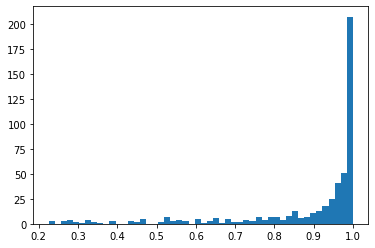

In [218]:
_ = plt.hist(pcts, bins=50)

In [219]:
df_test['results'] = results

In [220]:
p_clusters = df_test['results'].apply(lambda x: m1(x)[0] if m1(x)[1] >= 0.5 else -1)

In [221]:
np.mean(p_clusters != -1)

0.935672514619883

In [222]:
mode_clusters = df_embs.groupby('cluster_agglomerative')['classes'].apply(lambda x: x.value_counts(dropna=False).idxmax())

In [223]:
mode_clusters.loc[0]

'178836_p'

In [224]:
p_clusters.map(mode_clusters)

4262    105112_b
4357    112437_b
8213    113247_b
59           NaN
4645     74693_b
          ...   
4528     93083_b
5477     93472_b
5274     74693_b
6976     97707_b
712      99654_b
Name: results, Length: 513, dtype: object

In [225]:
(df_test.classes == p_clusters.map(mode_clusters)).mean()

0.8810916179337231

# LFW

In [237]:
from faces_clustering import FeatureExtractor

In [232]:
path = '/home/paulo/Documentos/0_LFW_dataset'

In [233]:
lfw = get_files_folder(path, criteria=is_image)

In [242]:
sample = random.sample(lfw, 513)

In [243]:
df_lfw = FeatureExtractor('senet50').extract(sample)
df_lfw.head(3)

,urls,embeddings
0,/home/paulo/Documentos/0_LFW_dataset/Dwayne_Wa...,"[2.0173535, 1.3786407, 0.05464342, 0.01336248,..."
1,/home/paulo/Documentos/0_LFW_dataset/James_Tra...,"[1.6418916, 0.9451376, 0.08249232, 4.298033, 0..."
2,/home/paulo/Documentos/0_LFW_dataset/Mike_Stef...,"[1.2372799, 7.67712, 0.059036005, 0.029944168,..."


In [244]:
lfw_query = [l.tolist() for l in df_lfw.embeddings.values]

In [247]:
_, results_lfw = searcher.closest_centroids(embs_query = lfw_query)

In [248]:
df_lfw['results'] = results_lfw

In [249]:
lfw_clusters = df_lfw['results'].apply(lambda x: m1(x)[0] if m1(x)[1] >= 0.5 else -1)

In [252]:
np.mean(lfw_clusters==-1)

0.9922027290448343